
# Individual Assignment - Image Classifier on C-Elegans Dataset (Computer Vision)

MBD-EN OCT20 - IE School of Human Scienses & Technology

Author: Pedro Lourenço dos Santos

Date: 13/06/2021

## Summary

The goal of this assignment is to build a classification pipeline to classify images of the C-Elegans dataset which contains gray level images of C. elegans, it has 2 categories: Live and Dead. The classification pipeline should not be based on deep neural networks, but on classical computer vision and machine learning approaches.

The notebook is divided in the following sections:
 - 1 - Baseline Model - Decision Tree
 - 2 - Histogram Operations and Contrast Improvement
  - 2.1 - Decision Tree with Contrast Stretching
  - 2.2 - Decision Tree with Histogram Equalization
 - 3 - Image Filtering
  - 3.1 - Decision Tree with Blurring
  - 3.2 - Decision Tree with Sharpening
  - 3.3 - Decision Tree with Edge Detection
 - 4 - Morphological Operations
  - 4.1 - Decision Tree with Dilation
  - 4.2 - Decision Tree with Erosion
  - 4.3 - Decision Tree with Opening
  - 4.4 - Decision Tree with Closing
 - 5 - Other Classifiers with Contrast Stretching
  - 5.1 - Gaussian Naive Bayes with Contrast Stretching
  - 5.2 - K-nearest Neighbors with Contrast Stretching
  - 5.3 - Support Vector Classification with Contrast Stretching
  - 5.4 - Random Forest with Contrast Stretching
  - 5.5 - Gradient Boosting with Contrast Stretching
 - 6 - Use the best model with new data
 - 7 - Conclusion


## Connection to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 1 - Baseline Model - Decision Tree

The first classifier to be trained will be a Decision Tree.

### Read data from Google Drive folder

In [2]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)
                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames


# Change the folder name to the name where the training images are located
training_folder_name =  '/content/gdrive/My Drive/MBD_2021/Computer_Vision/Data/train'

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print(sum(labels==0), 'images labeled', classnames[0])
print(sum(labels==1), 'images labeled', classnames[1])
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from dead
Reading data from live
70 features
70 labels
2 classes: ['dead', 'live']
35 images labeled dead
35 images labeled live
Feature Shape: (70, 361920)
Labels Shape: (70,)


After reading the data I conclude:
 - 70 labeled images are available in the train folder. 
 - The images are equally distributed between the 2 classes (35 dead and 35 live).
 - The feature array is a two-dimensional array (each image is itself an array). 
 - The labels array is a one dimensional array (each label is an integer value).

### Split the data into train and test

Now that the image data is prepared, I split the data into training (70%) and test (30%) subsets which gives 49 images for training and 21 images for testing.

Note: I defined random state in train_test_split to be 1 in order to be possible to make comparisons between different models without being influenced by a different train_test_split.

In [3]:
# split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=1)

print('Training records:',Y_train.size)
print('Test records:',Y_test.size)

Training records: 49
Test records: 21


### Train the classification model

Now I will use the prepared image data to train a model. In this case, I will define a pipeline that contains two steps:

1. Normalize the pixel values so that they are scaled between 0 and 1 - this can prevent high pixel density values from dominating the model training.

2. Train the model using a *Decision Tree* algorithm for classification.

In [4]:
# Train the model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

# Convert the training features to floats so they can be scaled
X_train_float = X_train.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier(random_state = 0)),
                        ])

# Use the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, Y_train)

print('classifier trained!')

Training model...
classifier trained!


### Evaluate the model

After training the model, I use it to predict labels for the test data and evaluate its precision, recall, and simple accuracy using the known labels. Then I plot the confusion matrix to evaluate how well the model performs for each class label.

Classifier Metrics:
              precision    recall  f1-score   support

        dead       0.80      1.00      0.89         4
        live       1.00      0.94      0.97        17

    accuracy                           0.95        21
   macro avg       0.90      0.97      0.93        21
weighted avg       0.96      0.95      0.95        21

Accuracy: 95.24%

 Confusion Matrix:


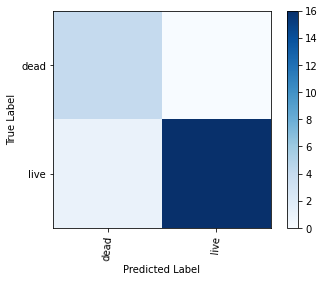

In [5]:
# Evaluate classifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert the test features for scaling
X_test_float = X_test.astype('float64')

print('Classifier Metrics:')
predictions = clf.predict(X_test)

print(metrics.classification_report(Y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(Y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Comparison of Model Accuracy

The next plot will be used to compare the train and test accuracy of the different models. So far only the baseline model is displayed.

Accuracy Train:  1.0
Accuracy Test:  0.9523809523809523


<Figure size 576x720 with 0 Axes>

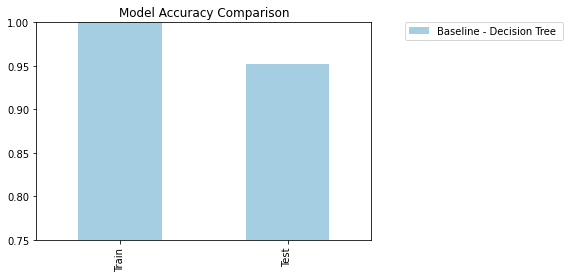

In [6]:
# defining plot compare of models and methods
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
result = {}
def plot_compare(d, label, new_training_score, new_test_score, ymin=0.75, ymax=1):
    d.update({label: [np.median(new_training_score),
                      np.median(new_test_score)]})
    plt.figure(figsize=(8,10))
    sns.set_palette("Paired")
    pd.DataFrame(d).set_index([pd.Index(["Train", "Test"])]).plot.bar()
    plt.ylim(ymin, ymax)
    plt.legend(bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0.)
    plt.title("Model Accuracy Comparison")
    plt.show()

train_accuracy = accuracy_score(Y_train, clf.predict(X_train))
print("Accuracy Train: ", train_accuracy)
test_accuracy = accuracy_score(Y_test, clf.predict(X_test_float))
print("Accuracy Test: ", test_accuracy)

plot_compare(result, "Baseline - Decision Tree ", train_accuracy, test_accuracy)

The test accuracy of the baseline decision tree model is around 95%.

## 2 - Histogram Operations and Contrast Improvement

The first feature engineering operations that I will perform are ralated with histogram operations and contrast improvement. Below I provide some definitions for a better understanding. After the definitions, I provide an example with one of the images from the dataset after contrast stretching and after histogram equalization.

**Histogram** is a graphical representation of the intensity distribution of an image. In simple terms, it represents the number of pixels for each intensity value considered.

**Contrast** is the difference in luminance or color that makes
an object distinguishable from other objects within the
same field of view. A valid way to check whether an image has a low or
high contrast is to plot the image **histogram**. An image with **lower contrast** will have the intensity values located in a **narrow range**.

**Linear : Contrast Stretching**

Contrast stretching, also called normalization, is a simple image enhancement technique that attempts to improve the contrast in an image by ‘stretching’ the range of intensity values it contains to span a desired range of values, the full range of pixel values that the image type concerned allows. Contrast stretching changes the distribution and range of the digital numbers assigned to each pixel in an image. This is normally done to accent image details that may be difficult for the human viewer to observe.

**Non Linear : Histogram Equalization**

Histogram Equalization is a computer image processing technique used to improve contrast in images. It accomplishes this by effectively spreading out the most frequent intensity values, i.e. stretching out the intensity range of the image. This method usually increases the global contrast of images when its usable data is represented by close contrast values. This allows for areas of lower local contrast to gain a higher contrast.



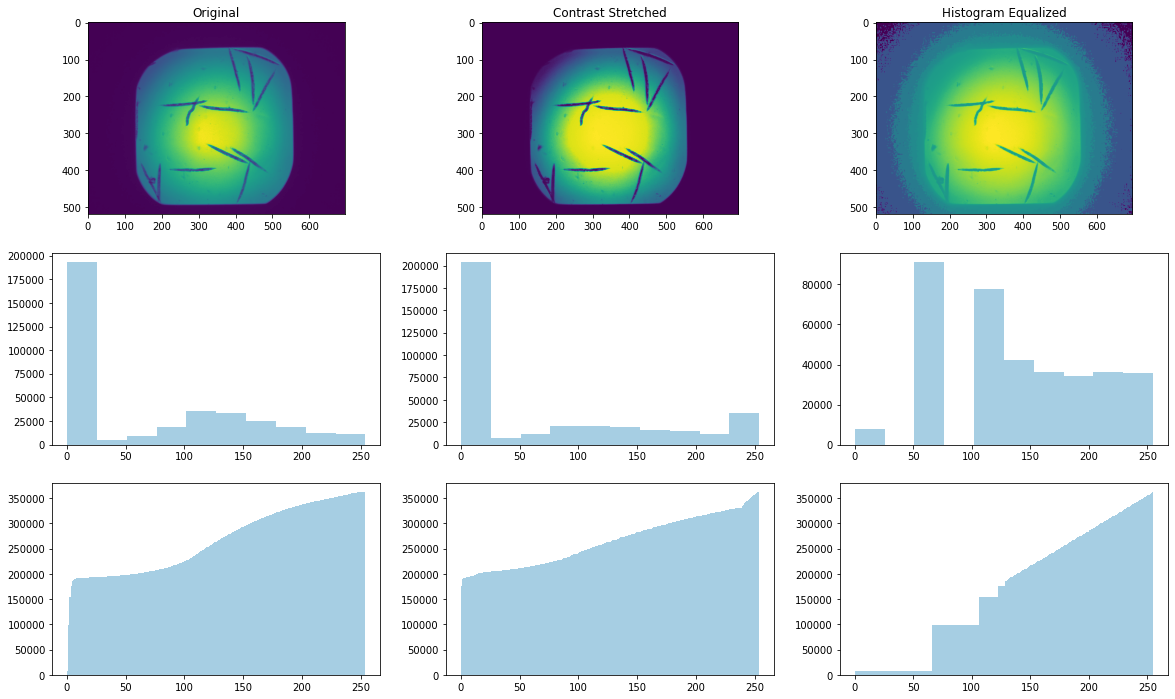

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
%matplotlib inline

# Load the image from the source file
image_file = '/content/gdrive/My Drive/MBD_2021/Computer_Vision/Data/train/dead/1649_1109_0003_Amp5-1_B_20070424_A17_w2_2D35B6EA-F8F9-4CFA-A39A-16792957F7C0.jpg'
image = mp_image.imread(image_file)

# Contrast Stretching
xp = [0, 64, 128, 192, 255]
fp = [0, 16, 128, 240, 255]
x = np.arange(256)
table = np.interp(x, xp, fp).astype('uint8')
image_ct = cv2.LUT(image, table)
 
# Histogram Equalization
image_eq = cv2.equalizeHist(image)

# Show the images
fig = plt.figure(figsize=(20, 12))

# Subplot for original image
a=fig.add_subplot(3,3,1)
imgplot = plt.imshow(image)
a.set_title('Original')

# Subplot for contrast stretched image
a=fig.add_subplot(3,3,2)
imgplot = plt.imshow(image_ct)
a.set_title('Contrast Stretched')

# Subplot for equalized image
a=fig.add_subplot(3,3,3)
imgplot = plt.imshow(image_eq)
a.set_title('Histogram Equalized')

# Subplots for histograms
a=fig.add_subplot(3,3,4)
imgplot = plt.hist(image.ravel())

a=fig.add_subplot(3,3,5)
imgplot = plt.hist(image_ct.ravel())

a=fig.add_subplot(3,3,6)
imgplot = plt.hist(image_eq.ravel())

# Subplots for CDFs (cumulative distribution functions)

a=fig.add_subplot(3,3,7)
imgplot = plt.hist(image.ravel(), bins=255, cumulative=True)

a=fig.add_subplot(3,3,8)
imgplot = plt.hist(image_ct.ravel(), bins=255, cumulative=True)

a=fig.add_subplot(3,3,9)
imgplot = plt.hist(image_eq.ravel(), bins=255, cumulative=True)

plt.show()

## 2.1 - Decision Tree with Contrast Stretching

### Read data and perform contrast stretching

In [8]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)

                # Contrast stretching
                xp = [0, 64, 128, 192, 255]
                fp = [0, 16, 128, 240, 255]
                x = np.arange(256)
                table = np.interp(x, xp, fp).astype('uint8')
                img = cv2.LUT(img, table)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames


# Change the folder name to the name where the training images are located
training_folder_name =  '/content/gdrive/My Drive/MBD_2021/Computer_Vision/Data/train'

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print(sum(labels==0), 'images labeled', classnames[0])
print(sum(labels==1), 'images labeled', classnames[1])
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from dead
Reading data from live
70 features
70 labels
2 classes: ['dead', 'live']
35 images labeled dead
35 images labeled live
Feature Shape: (70, 361920)
Labels Shape: (70,)


### Train the classification model

Now I will use the prepared image data to train a model. In this case, I will define a pipeline that contains two steps:

1. Normalize the pixel values so that they are scaled between 0 and 1 - this can prevent high pixel density values from dominating the model training.

2. Train the model using a *Decision Tree* algorithm for classification.

In [9]:
# split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=1)

print('Training records:',Y_train.size)
print('Test records:',Y_test.size)

# Train the model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

# Convert the training features to floats so they can be scaled
X_train_float = X_train.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier(random_state = 0)),
                        ])

# Use the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, Y_train)

print('classifier trained!')

Training records: 49
Test records: 21
Training model...
classifier trained!


### Evaluate the model

After training the model, I use it to predict labels for the test data and evaluate its precision, recall, and simple accuracy using the known labels. Then I plot the confusion matrix to evaluate how well the model performs for each class label.

Classifier Metrics:
              precision    recall  f1-score   support

        dead       1.00      1.00      1.00         4
        live       1.00      1.00      1.00        17

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

Accuracy: 100.00%

 Confusion Matrix:


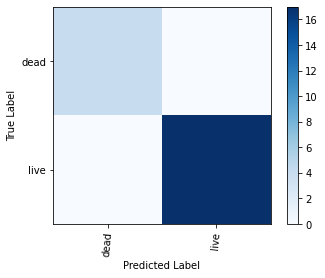

In [10]:
# Evaluate classifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert the test features for scaling
X_test_float = X_test.astype('float64')

print('Classifier Metrics:')
predictions = clf.predict(X_test)

print(metrics.classification_report(Y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(Y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Comparison of Model Accuracy

Accuracy Train:  1.0
Accuracy Test:  1.0


<Figure size 576x720 with 0 Axes>

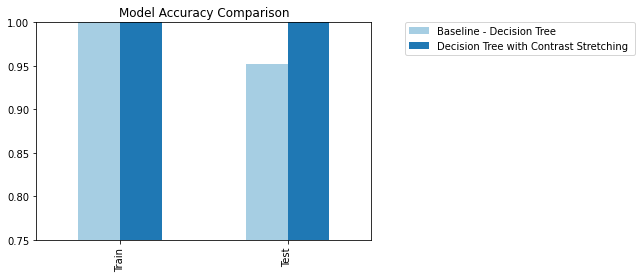

In [11]:
train_accuracy = accuracy_score(Y_train, clf.predict(X_train))
print("Accuracy Train: ", train_accuracy)
test_accuracy = accuracy_score(Y_test, clf.predict(X_test_float))
print("Accuracy Test: ", test_accuracy)

plot_compare(result, "Decision Tree with Contrast Stretching ", train_accuracy, test_accuracy)

By performing contrast stretching in the images, the test accuracy of the decision tree model improved to 100% (all 21 test images were predicted correctly).

## 2.2 - Decision Tree with Histogram Equalization

### Read data and perform histogram equalization

In [12]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)

                # Histogram Equalization
                img = cv2.equalizeHist(img)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames


# Change the folder name to the name where the training images are located
training_folder_name =  '/content/gdrive/My Drive/MBD_2021/Computer_Vision/Data/train'

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print(sum(labels==0), 'images labeled', classnames[0])
print(sum(labels==1), 'images labeled', classnames[1])
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from dead
Reading data from live
70 features
70 labels
2 classes: ['dead', 'live']
35 images labeled dead
35 images labeled live
Feature Shape: (70, 361920)
Labels Shape: (70,)


### Train the classification model

Now I will use the prepared image data to train a model. In this case, I will define a pipeline that contains two steps:

1. Normalize the pixel values so that they are scaled between 0 and 1 - this can prevent high pixel density values from dominating the model training.

2. Train the model using a *Decision Tree* algorithm for classification.

In [13]:
# split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=1)

print('Training records:',Y_train.size)
print('Test records:',Y_test.size)

# Train the model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

# Convert the training features to floats so they can be scaled
X_train_float = X_train.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier(random_state = 0)),
                        ])

# Use the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, Y_train)

print('classifier trained!')

Training records: 49
Test records: 21
Training model...
classifier trained!


### Evaluate the model

After training the model, I use it to predict labels for the test data and evaluate its precision, recall, and simple accuracy using the known labels. Then I plot the confusion matrix to evaluate how well the model performs for each class label.

Classifier Metrics:
              precision    recall  f1-score   support

        dead       0.80      1.00      0.89         4
        live       1.00      0.94      0.97        17

    accuracy                           0.95        21
   macro avg       0.90      0.97      0.93        21
weighted avg       0.96      0.95      0.95        21

Accuracy: 95.24%

 Confusion Matrix:


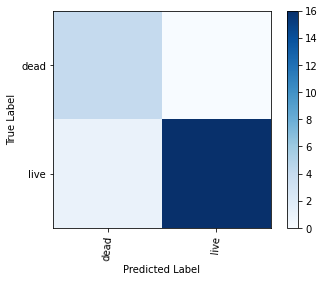

In [14]:
# Evaluate classifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert the test features for scaling
X_test_float = X_test.astype('float64')

print('Classifier Metrics:')
predictions = clf.predict(X_test)

print(metrics.classification_report(Y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(Y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Comparison of Model Accuracy

Accuracy Train:  1.0
Accuracy Test:  0.9523809523809523


<Figure size 576x720 with 0 Axes>

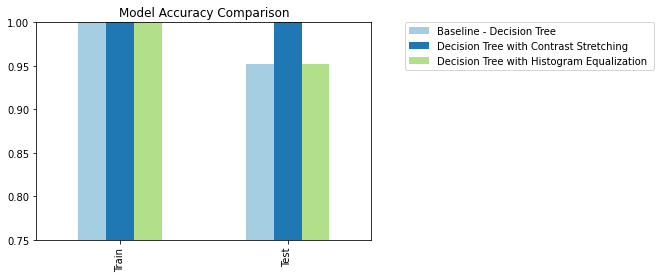

In [15]:
train_accuracy = accuracy_score(Y_train, clf.predict(X_train))
print("Accuracy Train: ", train_accuracy)
test_accuracy = accuracy_score(Y_test, clf.predict(X_test_float))
print("Accuracy Test: ", test_accuracy)

plot_compare(result, "Decision Tree with Histogram Equalization ", train_accuracy, test_accuracy)

Histogram equalization did not have the same improvement effect as contrast stretching in the test accuracy as it stayed at around 95%, similar to the baseline model.

## 3 - Image Filtering

The next feature engineering operations that I will perform are ralated with image filtering. Below I provide some definitions for a better understanding. After the definitions, I provide an example with one of the images from the dataset after blurring and sharpening.

As for one dimensional signals, images also can be filtered with various
low pass filters (LPF), high pass filters (HPF), etc. A LPF helps in
removing noise , or blurring the image. A HPF filters helps in finding
edges in an image.

**Blurring** 

Blurring is an example of applying a low-pass filter to an image. In computer vision, the term “low-pass filter” applies to removing noise from an image while leaving the majority of the image intact. 

**Sharpening**

Sharpening filters are used to enhance the edges of objects and adjust the contrast and the shade characteristics. In combination with threshold they can be used as edge detectors. Sharpening or high-pass filters let high frequencies pass and reduce the lower frequencies and are extremely sensitive to shut noise.

**Edge Detection**

In computer vision, edges are sudden discontinuities in an image, which can arise from surface normal, surface color, depth, illumination, or other discontinuities. Edges are important for two main reasons. 1) Most semantic and shape information can be deduced from them, so we can perform object recognition and analyze perspectives and geometry of an image. 2) They are a more compact representation than pixels.

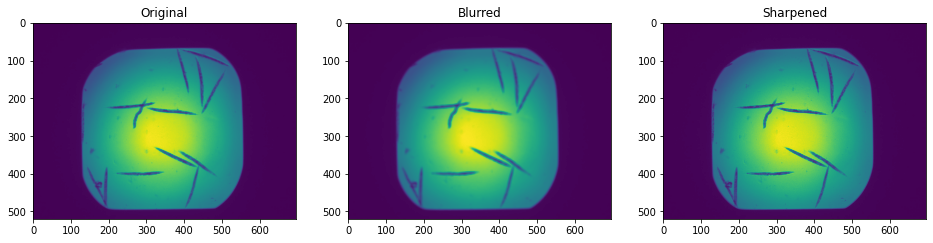

In [16]:
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
%matplotlib inline

# Load the image from the source file
image_file = '/content/gdrive/My Drive/MBD_2021/Computer_Vision/Data/train/dead/1649_1109_0003_Amp5-1_B_20070424_A17_w2_2D35B6EA-F8F9-4CFA-A39A-16792957F7C0.jpg'
image = Image.open(image_file)

blurred_image = image.filter(ImageFilter.BLUR)
sharpened_image = image.filter(ImageFilter.SHARPEN)

# Display it
fig = plt.figure(figsize=(16, 12))

# Plot original image
a=fig.add_subplot(1, 3, 1)
image_plot_1 = plt.imshow(image)
a.set_title("Original")

# Plot blurred image
a=fig.add_subplot(1, 3, 2)
image_plot_2 = plt.imshow(blurred_image)
a.set_title("Blurred")

# Plot sharpened image
a=fig.add_subplot(1, 3, 3)
image_plot_3 = plt.imshow(sharpened_image)
a.set_title("Sharpened")

plt.show()

## 3.1 - Decision Tree with Blurring

### Read data and perform blurring

In [17]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)

                # Blurring
                img = cv2.GaussianBlur(img, (5,5), cv2.BORDER_DEFAULT)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames


# Change the folder name to the name where the training images are located
training_folder_name =  '/content/gdrive/My Drive/MBD_2021/Computer_Vision/Data/train'

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print(sum(labels==0), 'images labeled', classnames[0])
print(sum(labels==1), 'images labeled', classnames[1])
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from dead
Reading data from live
70 features
70 labels
2 classes: ['dead', 'live']
35 images labeled dead
35 images labeled live
Feature Shape: (70, 361920)
Labels Shape: (70,)


### Train the classification model

Now I will use the prepared image data to train a model. In this case, I will define a pipeline that contains two steps:

1. Normalize the pixel values so that they are scaled between 0 and 1 - this can prevent high pixel density values from dominating the model training.

2. Train the model using a *Decision Tree* algorithm for classification.

In [18]:
# split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=1)

print('Training records:',Y_train.size)
print('Test records:',Y_test.size)

# Train the model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

# Convert the training features to floats so they can be scaled
X_train_float = X_train.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier(random_state = 0)),
                        ])

# Use the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, Y_train)

print('classifier trained!')

Training records: 49
Test records: 21
Training model...
classifier trained!


### Evaluate the model

After training the model, I use it to predict labels for the test data and evaluate its precision, recall, and simple accuracy using the known labels. Then I plot the confusion matrix to evaluate how well the model performs for each class label.

Classifier Metrics:
              precision    recall  f1-score   support

        dead       0.80      1.00      0.89         4
        live       1.00      0.94      0.97        17

    accuracy                           0.95        21
   macro avg       0.90      0.97      0.93        21
weighted avg       0.96      0.95      0.95        21

Accuracy: 95.24%

 Confusion Matrix:


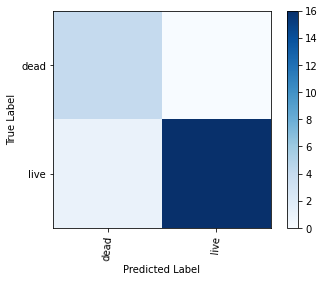

In [19]:
# Evaluate classifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert the test features for scaling
X_test_float = X_test.astype('float64')

print('Classifier Metrics:')
predictions = clf.predict(X_test)

print(metrics.classification_report(Y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(Y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Comparison of Model Accuracy

Accuracy Train:  1.0
Accuracy Test:  0.9523809523809523


<Figure size 576x720 with 0 Axes>

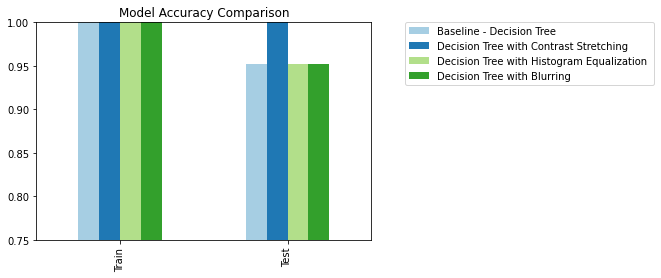

In [20]:
train_accuracy = accuracy_score(Y_train, clf.predict(X_train))
print("Accuracy Train: ", train_accuracy)
test_accuracy = accuracy_score(Y_test, clf.predict(X_test_float))
print("Accuracy Test: ", test_accuracy)

plot_compare(result, "Decision Tree with Blurring", train_accuracy, test_accuracy)

Blurring transformation also shared a similar test accuracy around 95% as the baseline model. The good baseline performance associated with a low number of train/test data can explain these similar results.

## 3.2 - Decision Tree with Sharpening

### Read data and perform sharpening

In [21]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)

                # Sharpening
                kernel = np.array([[-2,-2,-2], 
                                   [-2, 32,-2],
                                   [-2,-2,-2]])
                img = cv2.filter2D(img, -1, kernel)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames


# Change the folder name to the name where the training images are located
training_folder_name =  '/content/gdrive/My Drive/MBD_2021/Computer_Vision/Data/train'

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print(sum(labels==0), 'images labeled', classnames[0])
print(sum(labels==1), 'images labeled', classnames[1])
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from dead
Reading data from live
70 features
70 labels
2 classes: ['dead', 'live']
35 images labeled dead
35 images labeled live
Feature Shape: (70, 361920)
Labels Shape: (70,)


### Train the classification model

Now I will use the prepared image data to train a model. In this case, I will define a pipeline that contains two steps:

1. Normalize the pixel values so that they are scaled between 0 and 1 - this can prevent high pixel density values from dominating the model training.

2. Train the model using a *Decision Tree* algorithm for classification.

In [22]:
# split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=1)

print('Training records:',Y_train.size)
print('Test records:',Y_test.size)

# Train the model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

# Convert the training features to floats so they can be scaled
X_train_float = X_train.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier(random_state = 0)),
                        ])

# Use the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, Y_train)

print('classifier trained!')

Training records: 49
Test records: 21
Training model...
classifier trained!


### Evaluate the model

After training the model, I use it to predict labels for the test data and evaluate its precision, recall, and simple accuracy using the known labels. Then I plot the confusion matrix to evaluate how well the model performs for each class label.

Classifier Metrics:
              precision    recall  f1-score   support

        dead       0.80      1.00      0.89         4
        live       1.00      0.94      0.97        17

    accuracy                           0.95        21
   macro avg       0.90      0.97      0.93        21
weighted avg       0.96      0.95      0.95        21

Accuracy: 95.24%

 Confusion Matrix:


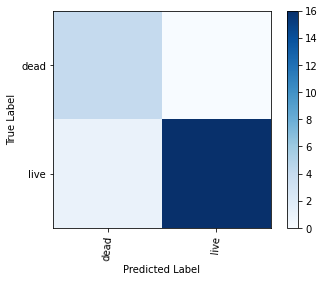

In [23]:
# Evaluate classifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert the test features for scaling
X_test_float = X_test.astype('float64')

print('Classifier Metrics:')
predictions = clf.predict(X_test)

print(metrics.classification_report(Y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(Y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Comparison of Model Accuracy

Accuracy Train:  1.0
Accuracy Test:  0.9523809523809523


<Figure size 576x720 with 0 Axes>

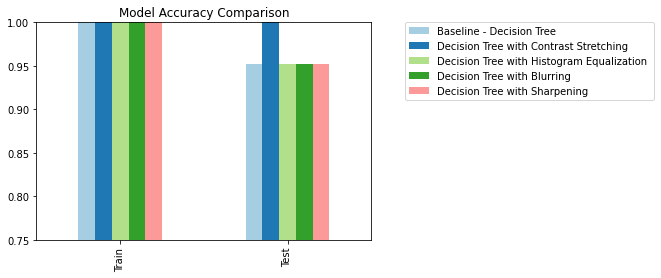

In [24]:
train_accuracy = accuracy_score(Y_train, clf.predict(X_train))
print("Accuracy Train: ", train_accuracy)
test_accuracy = accuracy_score(Y_test, clf.predict(X_test_float))
print("Accuracy Test: ", test_accuracy)

plot_compare(result, "Decision Tree with Sharpening", train_accuracy, test_accuracy)

The decision tree model with sharpening also had a similar test accuracy result. So far, only contrast stretching improved the baseline model.

It is interesting also to observe a better live precision in the confusion matrix than dead precision.

## 3.3 - Decision Tree with Edge Detection

### Read data and perform sobel edge detection

In [25]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)

                #Sobel edge detection
                sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
                sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
                #print(sobelx.type)
                #magniture
                sobel=np.sqrt(np.multiply(sobelx,sobelx)+np.multiply(sobely,sobely))
                img = np.concatenate((img, sobel), axis=0)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames


# Change the folder name to the name where the training images are located
training_folder_name =  '/content/gdrive/My Drive/MBD_2021/Computer_Vision/Data/train'

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print(sum(labels==0), 'images labeled', classnames[0])
print(sum(labels==1), 'images labeled', classnames[1])
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from dead
Reading data from live
70 features
70 labels
2 classes: ['dead', 'live']
35 images labeled dead
35 images labeled live
Feature Shape: (70, 723840)
Labels Shape: (70,)


### Train the classification model

Now I will use the prepared image data to train a model. In this case, I will define a pipeline that contains two steps:

1. Normalize the pixel values so that they are scaled between 0 and 1 - this can prevent high pixel density values from dominating the model training.

2. Train the model using a *Decision Tree* algorithm for classification.

In [26]:
# split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=1)

print('Training records:',Y_train.size)
print('Test records:',Y_test.size)

# Train the model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

# Convert the training features to floats so they can be scaled
X_train_float = X_train.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier(random_state = 0)),
                        ])

# Use the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, Y_train)

print('classifier trained!')

Training records: 49
Test records: 21
Training model...
classifier trained!


### Evaluate the model

After training the model, I use it to predict labels for the test data and evaluate its precision, recall, and simple accuracy using the known labels. Then I plot the confusion matrix to evaluate how well the model performs for each class label.

Classifier Metrics:
              precision    recall  f1-score   support

        dead       0.57      1.00      0.73         4
        live       1.00      0.82      0.90        17

    accuracy                           0.86        21
   macro avg       0.79      0.91      0.82        21
weighted avg       0.92      0.86      0.87        21

Accuracy: 85.71%

 Confusion Matrix:


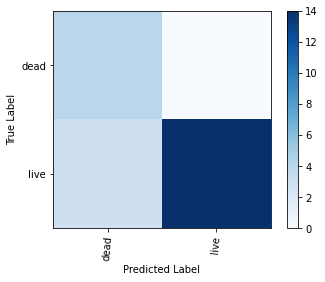

In [27]:
# Evaluate classifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert the test features for scaling
X_test_float = X_test.astype('float64')

print('Classifier Metrics:')
predictions = clf.predict(X_test)

print(metrics.classification_report(Y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(Y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Comparison of Model Accuracy

Accuracy Train:  1.0
Accuracy Test:  0.8571428571428571


<Figure size 576x720 with 0 Axes>

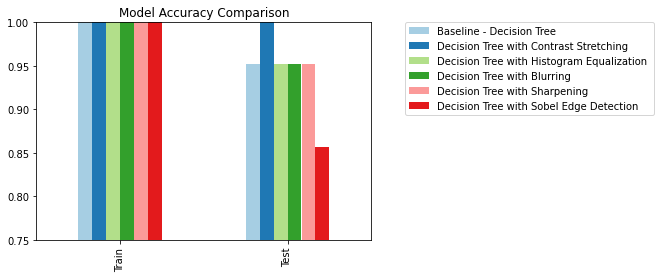

In [28]:
train_accuracy = accuracy_score(Y_train, clf.predict(X_train))
print("Accuracy Train: ", train_accuracy)
test_accuracy = accuracy_score(Y_test, clf.predict(X_test_float))
print("Accuracy Test: ", test_accuracy)

plot_compare(result, "Decision Tree with Sobel Edge Detection", train_accuracy, test_accuracy)

Sobel edge detection transformation deteriorated test accuracy result to around 86%. 

In the confusion matrix above we see a worse precision for dead images around 57%.

## 4 - Morphological Operations

The next image transformations that I will perform are ralated with morphological operations. Below I provide some definitions for a better understanding. After the definitions, I provide an example with one of the images from the dataset after dilation and after erosion.

**Morphological operations** are a collection of non linear operations related to the shape or morphology of features in an image. 

**Dilation** adds pixels to the boundaries of objects in an image. It is useful in joining broken parts of an object.

**Erosion** removes pixels on object boundaries. It is useful for removing small white noises or to detach two connected objects for example.

**Opening** starts with an erosion and then a dilation. It removes small regions and eliminates peninsulas on the boundary.

**Closing** starts with a dilation and then an erosion. It fills internal holes in a region, while maintaining approximated pixel count and eliminates inlets on the boundary.

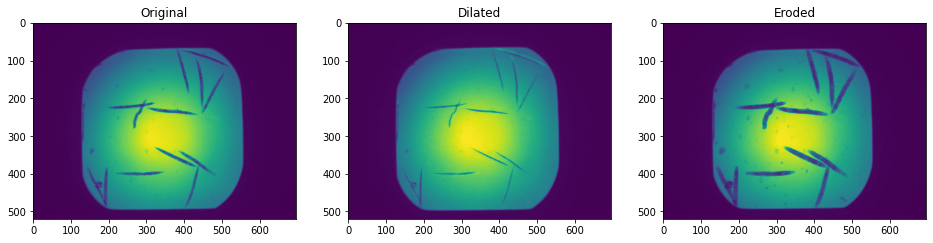

In [29]:
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
%matplotlib inline


# Load the image from the source file
image_file = '/content/gdrive/My Drive/MBD_2021/Computer_Vision/Data/train/dead/1649_1109_0003_Amp5-1_B_20070424_A17_w2_2D35B6EA-F8F9-4CFA-A39A-16792957F7C0.jpg'
img = plt.imread(image_file)

kernel = np.ones((5,5),np.uint8)
dilated_image = cv2.dilate(img, kernel, iterations = 1)
eroded_image = cv2.erode(img, kernel, iterations = 1)

# Display it
fig = plt.figure(figsize=(16, 12))

# Plot original image
a=fig.add_subplot(1, 3, 1)
image_plot_1 = plt.imshow(img)
a.set_title("Original")

# Plot dilated image
a=fig.add_subplot(1, 3, 2)
image_plot_2 = plt.imshow(dilated_image)
a.set_title("Dilated")

# Plot eroded image
a=fig.add_subplot(1, 3, 3)
image_plot_3 = plt.imshow(eroded_image)
a.set_title("Eroded")

plt.show()

## 4.1 - Decision Tree with Dilation

### Read data and perform dilation

In [30]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)

                # Dilation
                kernel = np.ones((5,5),np.uint8)
                img = cv2.dilate(img, kernel, iterations = 1)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames


# Change the folder name to the name where the training images are located
training_folder_name =  '/content/gdrive/My Drive/MBD_2021/Computer_Vision/Data/train'

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print(sum(labels==0), 'images labeled', classnames[0])
print(sum(labels==1), 'images labeled', classnames[1])
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from dead
Reading data from live
70 features
70 labels
2 classes: ['dead', 'live']
35 images labeled dead
35 images labeled live
Feature Shape: (70, 361920)
Labels Shape: (70,)


### Train the classification model

Now I will use the prepared image data to train a model. In this case, I will define a pipeline that contains two steps:

1. Normalize the pixel values so that they are scaled between 0 and 1 - this can prevent high pixel density values from dominating the model training.

2. Train the model using a *Decision Tree* algorithm for classification.

In [31]:
# split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=1)

print('Training records:',Y_train.size)
print('Test records:',Y_test.size)

# Train the model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

# Convert the training features to floats so they can be scaled
X_train_float = X_train.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier(random_state = 0)),
                        ])

# Use the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, Y_train)

print('classifier trained!')

Training records: 49
Test records: 21
Training model...
classifier trained!


### Evaluate the model

After training the model, I use it to predict labels for the test data and evaluate its precision, recall, and simple accuracy using the known labels. Then I plot the confusion matrix to evaluate how well the model performs for each class label.

Classifier Metrics:
              precision    recall  f1-score   support

        dead       0.80      1.00      0.89         4
        live       1.00      0.94      0.97        17

    accuracy                           0.95        21
   macro avg       0.90      0.97      0.93        21
weighted avg       0.96      0.95      0.95        21

Accuracy: 95.24%

 Confusion Matrix:


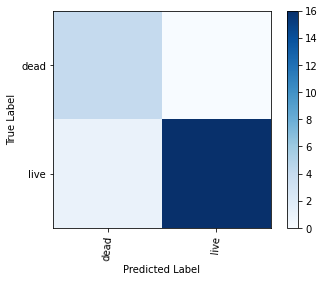

In [32]:
# Evaluate classifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert the test features for scaling
X_test_float = X_test.astype('float64')

print('Classifier Metrics:')
predictions = clf.predict(X_test)

print(metrics.classification_report(Y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(Y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Comparison of Model Accuracy

Accuracy Train:  1.0
Accuracy Test:  0.9523809523809523


<Figure size 576x720 with 0 Axes>

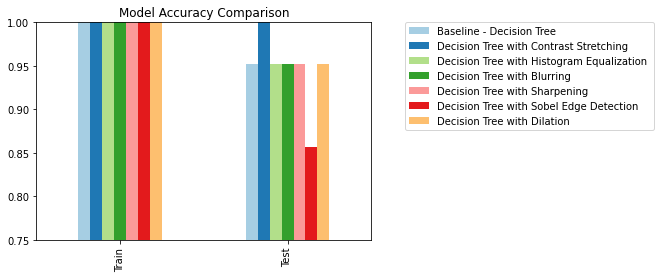

In [33]:
train_accuracy = accuracy_score(Y_train, clf.predict(X_train))
print("Accuracy Train: ", train_accuracy)
test_accuracy = accuracy_score(Y_test, clf.predict(X_test_float))
print("Accuracy Test: ", test_accuracy)

plot_compare(result, "Decision Tree with Dilation", train_accuracy, test_accuracy)

Dilation shows a similar accuracy result in test as the baseline model around 95%.



## 4.2 - Decision Tree with Erosion

### Read data and perform erosion

In [34]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)

                #Erosion
                kernel = np.ones((5,5),np.uint8)
                img = cv2.erode(img, kernel, iterations = 1)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames


# Change the folder name to the name where the training images are located
training_folder_name =  '/content/gdrive/My Drive/MBD_2021/Computer_Vision/Data/train'

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print(sum(labels==0), 'images labeled', classnames[0])
print(sum(labels==1), 'images labeled', classnames[1])
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from dead
Reading data from live
70 features
70 labels
2 classes: ['dead', 'live']
35 images labeled dead
35 images labeled live
Feature Shape: (70, 361920)
Labels Shape: (70,)


### Train the classification model

Now I will use the prepared image data to train a model. In this case, I will define a pipeline that contains two steps:

1. Normalize the pixel values so that they are scaled between 0 and 1 - this can prevent high pixel density values from dominating the model training.

2. Train the model using a *Decision Tree* algorithm for classification.

In [35]:
# split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=1)

print('Training records:',Y_train.size)
print('Test records:',Y_test.size)

# Train the model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

# Convert the training features to floats so they can be scaled
X_train_float = X_train.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier(random_state = 0)),
                        ])

# Use the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, Y_train)

print('classifier trained!')

Training records: 49
Test records: 21
Training model...
classifier trained!


### Evaluate the model

After training the model, I use it to predict labels for the test data and evaluate its precision, recall, and simple accuracy using the known labels. Then I plot the confusion matrix to evaluate how well the model performs for each class label.

Classifier Metrics:
              precision    recall  f1-score   support

        dead       0.57      1.00      0.73         4
        live       1.00      0.82      0.90        17

    accuracy                           0.86        21
   macro avg       0.79      0.91      0.82        21
weighted avg       0.92      0.86      0.87        21

Accuracy: 85.71%

 Confusion Matrix:


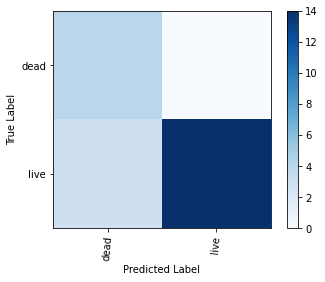

In [36]:
# Evaluate classifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert the test features for scaling
X_test_float = X_test.astype('float64')

print('Classifier Metrics:')
predictions = clf.predict(X_test)

print(metrics.classification_report(Y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(Y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Comparison of Model Accuracy

Accuracy Train:  1.0
Accuracy Test:  0.8571428571428571


<Figure size 576x720 with 0 Axes>

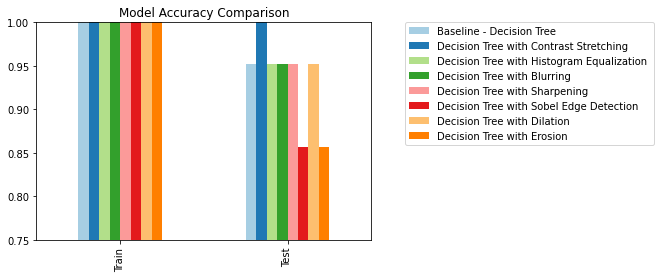

In [37]:
train_accuracy = accuracy_score(Y_train, clf.predict(X_train))
print("Accuracy Train: ", train_accuracy)
test_accuracy = accuracy_score(Y_test, clf.predict(X_test_float))
print("Accuracy Test: ", test_accuracy)

plot_compare(result, "Decision Tree with Erosion", train_accuracy, test_accuracy)

Erosion shows an accuracy of around 86% in test which is worse than the baseline model. It is a similar result to sobel edge detection.


## 4.3 - Decision Tree with Opening

### Read data and perform opening

In [38]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)

                # Opening
                kernel = np.ones((5,5),np.uint8)
                img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames


# Change the folder name to the name where the training images are located
training_folder_name =  '/content/gdrive/My Drive/MBD_2021/Computer_Vision/Data/train'

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print(sum(labels==0), 'images labeled', classnames[0])
print(sum(labels==1), 'images labeled', classnames[1])
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from dead
Reading data from live
70 features
70 labels
2 classes: ['dead', 'live']
35 images labeled dead
35 images labeled live
Feature Shape: (70, 361920)
Labels Shape: (70,)


### Train the classification model

Now I will use the prepared image data to train a model. In this case, I will define a pipeline that contains two steps:

1. Normalize the pixel values so that they are scaled between 0 and 1 - this can prevent high pixel density values from dominating the model training.

2. Train the model using a *Decision Tree* algorithm for classification.

In [39]:
# split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=1)

print('Training records:',Y_train.size)
print('Test records:',Y_test.size)

# Train the model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

# Convert the training features to floats so they can be scaled
X_train_float = X_train.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier(random_state = 0)),
                        ])

# Use the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, Y_train)

print('classifier trained!')

Training records: 49
Test records: 21
Training model...
classifier trained!


### Evaluate the model

After training the model, I use it to predict labels for the test data and evaluate its precision, recall, and simple accuracy using the known labels. Then I plot the confusion matrix to evaluate how well the model performs for each class label.

Classifier Metrics:
              precision    recall  f1-score   support

        dead       0.80      1.00      0.89         4
        live       1.00      0.94      0.97        17

    accuracy                           0.95        21
   macro avg       0.90      0.97      0.93        21
weighted avg       0.96      0.95      0.95        21

Accuracy: 95.24%

 Confusion Matrix:


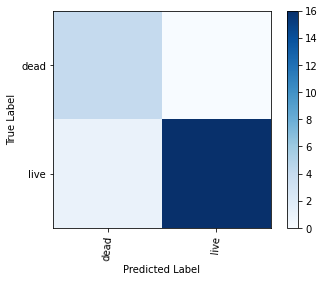

In [40]:
# Evaluate classifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert the test features for scaling
X_test_float = X_test.astype('float64')

print('Classifier Metrics:')
predictions = clf.predict(X_test)

print(metrics.classification_report(Y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(Y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Comparison of Model Accuracy

Accuracy Train:  1.0
Accuracy Test:  0.9523809523809523


<Figure size 576x720 with 0 Axes>

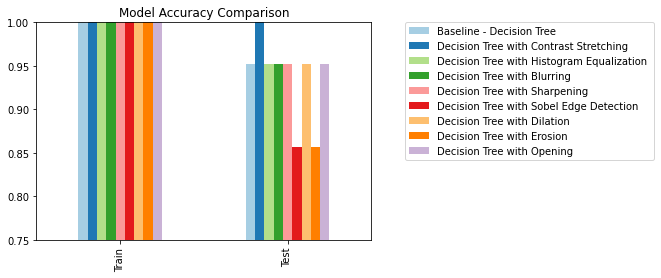

In [41]:
train_accuracy = accuracy_score(Y_train, clf.predict(X_train))
print("Accuracy Train: ", train_accuracy)
test_accuracy = accuracy_score(Y_test, clf.predict(X_test_float))
print("Accuracy Test: ", test_accuracy)

plot_compare(result, "Decision Tree with Opening", train_accuracy, test_accuracy)

Opening transformation keeps the test accuracy 95%, similar to the baseline model.

## 4.4 - Decision Tree with Closing

### Read data and perform closing

In [42]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)

                #Closing
                kernel = np.ones((5,5),np.uint8)
                img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames


# Change the folder name to the name where the training images are located
training_folder_name =  '/content/gdrive/My Drive/MBD_2021/Computer_Vision/Data/train'

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print(sum(labels==0), 'images labeled', classnames[0])
print(sum(labels==1), 'images labeled', classnames[1])
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from dead
Reading data from live
70 features
70 labels
2 classes: ['dead', 'live']
35 images labeled dead
35 images labeled live
Feature Shape: (70, 361920)
Labels Shape: (70,)


### Train the classification model

Now I will use the prepared image data to train a model. In this case, I will define a pipeline that contains two steps:

1. Normalize the pixel values so that they are scaled between 0 and 1 - this can prevent high pixel density values from dominating the model training.

2. Train the model using a *Decision Tree* algorithm for classification.

In [43]:
# split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=1)

print('Training records:',Y_train.size)
print('Test records:',Y_test.size)

# Train the model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

# Convert the training features to floats so they can be scaled
X_train_float = X_train.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', DecisionTreeClassifier(random_state = 0)),
                        ])

# Use the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, Y_train)

print('classifier trained!')

Training records: 49
Test records: 21
Training model...
classifier trained!


### Evaluate the model

After training the model, I use it to predict labels for the test data and evaluate its precision, recall, and simple accuracy using the known labels. Then I plot the confusion matrix to evaluate how well the model performs for each class label.

Classifier Metrics:
              precision    recall  f1-score   support

        dead       0.80      1.00      0.89         4
        live       1.00      0.94      0.97        17

    accuracy                           0.95        21
   macro avg       0.90      0.97      0.93        21
weighted avg       0.96      0.95      0.95        21

Accuracy: 95.24%

 Confusion Matrix:


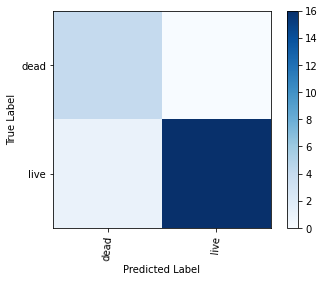

In [44]:
# Evaluate classifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert the test features for scaling
X_test_float = X_test.astype('float64')

print('Classifier Metrics:')
predictions = clf.predict(X_test)

print(metrics.classification_report(Y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(Y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Comparison of Model Accuracy

Accuracy Train:  1.0
Accuracy Test:  0.9523809523809523


<Figure size 576x720 with 0 Axes>

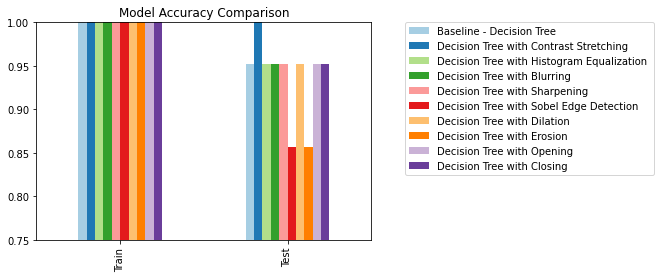

In [45]:
train_accuracy = accuracy_score(Y_train, clf.predict(X_train))
print("Accuracy Train: ", train_accuracy)
test_accuracy = accuracy_score(Y_test, clf.predict(X_test_float))
print("Accuracy Test: ", test_accuracy)

plot_compare(result, "Decision Tree with Closing", train_accuracy, test_accuracy)

Closing transformation keeps the test accuracy 95%, similar to the baseline model and the previous opening transformation for example.

## 5 - Other Classifiers with Contrast Stretching

Since contrast stretching was the image transformation with the best accuracy result on test data, I am now going to test the performance of other classifiers with the same image transformation:
  - 5.1 - Gaussian Naive Bayes with Contrast Stretching
  - 5.2 - K-nearest Neighbors with Contrast Stretching
  - 5.3 - Support Vector Classification with Contrast Stretching
  - 5.4 - Random Forest with Contrast Stretching
  - 5.5 - Gradient Boosting with Contrast Stretching


### Read data and perform contrast stretching

In [46]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.feature import hog

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)

                # Contrast stretching
                xp = [0, 64, 128, 192, 255]
                fp = [0, 16, 128, 240, 255]
                x = np.arange(256)
                table = np.interp(x, xp, fp).astype('uint8')
                img = cv2.LUT(img, table)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames


# Change the folder name to the name where the training images are located
training_folder_name =  '/content/gdrive/My Drive/MBD_2021/Computer_Vision/Data/train'

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)
print(sum(labels==0), 'images labeled', classnames[0])
print(sum(labels==1), 'images labeled', classnames[1])
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Reading data from dead
Reading data from live
70 features
70 labels
2 classes: ['dead', 'live']
35 images labeled dead
35 images labeled live
Feature Shape: (70, 361920)
Labels Shape: (70,)


## 5.1 - Gaussian Naive Bayes with Contrast Stretching

### Train the classification model

Now I will use the prepared image data to train a model. In this case, I will define a pipeline that contains two steps:

1. Normalize the pixel values so that they are scaled between 0 and 1 - this can prevent high pixel density values from dominating the model training.

2. Train the model using a *Gaussian Naive Bayes* algorithm for classification.

In [47]:
# split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=1)

print('Training records:',Y_train.size)
print('Test records:',Y_test.size)

# Train the model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB

# Convert the training features to floats so they can be scaled
X_train_float = X_train.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', GaussianNB()),
                        ])

# Use the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, Y_train)

print('classifier trained!')

Training records: 49
Test records: 21
Training model...
classifier trained!


### Evaluate the model

After training the model, I use it to predict labels for the test data and evaluate its precision, recall, and simple accuracy using the known labels. Then I plot the confusion matrix to evaluate how well the model performs for each class label.

Classifier Metrics:
              precision    recall  f1-score   support

        dead       0.75      0.75      0.75         4
        live       0.94      0.94      0.94        17

    accuracy                           0.90        21
   macro avg       0.85      0.85      0.85        21
weighted avg       0.90      0.90      0.90        21

Accuracy: 90.48%

 Confusion Matrix:


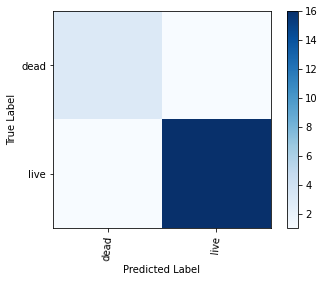

In [48]:
# Evaluate classifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert the test features for scaling
X_test_float = X_test.astype('float64')

print('Classifier Metrics:')
predictions = clf.predict(X_test)

print(metrics.classification_report(Y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(Y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Comparison of Model Accuracy

Accuracy Train:  1.0
Accuracy Test:  0.9047619047619048


<Figure size 576x720 with 0 Axes>

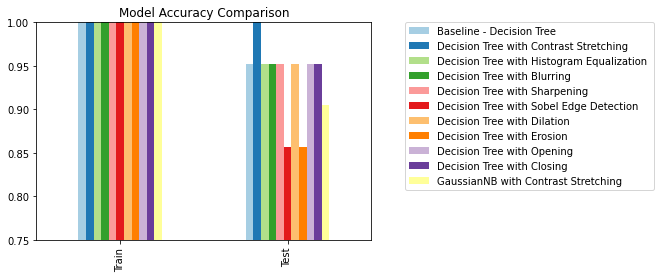

In [49]:
train_accuracy = accuracy_score(Y_train, clf.predict(X_train))
print("Accuracy Train: ", train_accuracy)
test_accuracy = accuracy_score(Y_test, clf.predict(X_test_float))
print("Accuracy Test: ", test_accuracy)

plot_compare(result, "GaussianNB with Contrast Stretching", train_accuracy, test_accuracy)

Gaussian Naive Bayes performs worse than Decision Tree. The test accuracy stayed at around 90% with Gaussian Naive Bayes with contrast stretching versus 100% for Decision Tree with constrast stretching.

## 5.2 - K-nearest Neighbors with Contrast Stretching

### Train the classification model

Now I will use the prepared image data to train a model. In this case, I will define a pipeline that contains two steps:

1. Normalize the pixel values so that they are scaled between 0 and 1 - this can prevent high pixel density values from dominating the model training.

2. Train the model using a *K-nearest Neighbors* algorithm for classification.

In [50]:
# split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=1)

print('Training records:',Y_train.size)
print('Test records:',Y_test.size)

# Train the model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

# Convert the training features to floats so they can be scaled
X_train_float = X_train.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', KNeighborsClassifier()),
                        ])

# Use the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, Y_train)

print('classifier trained!')

Training records: 49
Test records: 21
Training model...
classifier trained!


### Evaluate the model

After training the model, I use it to predict labels for the test data and evaluate its precision, recall, and simple accuracy using the known labels. Then I plot the confusion matrix to evaluate how well the model performs for each class label.

Classifier Metrics:
              precision    recall  f1-score   support

        dead       0.67      1.00      0.80         4
        live       1.00      0.88      0.94        17

    accuracy                           0.90        21
   macro avg       0.83      0.94      0.87        21
weighted avg       0.94      0.90      0.91        21

Accuracy: 90.48%

 Confusion Matrix:


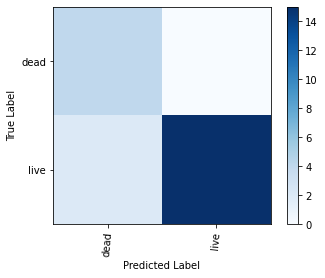

In [51]:
# Evaluate classifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert the test features for scaling
X_test_float = X_test.astype('float64')

print('Classifier Metrics:')
predictions = clf.predict(X_test)

print(metrics.classification_report(Y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(Y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Comparison of Model Accuracy

Accuracy Train:  0.9387755102040817
Accuracy Test:  0.9047619047619048


<Figure size 576x720 with 0 Axes>

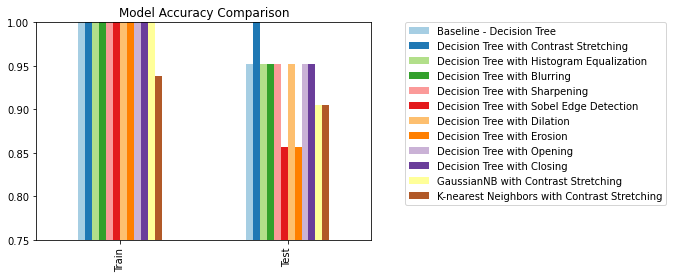

In [52]:
train_accuracy = accuracy_score(Y_train, clf.predict(X_train))
print("Accuracy Train: ", train_accuracy)
test_accuracy = accuracy_score(Y_test, clf.predict(X_test_float))
print("Accuracy Test: ", test_accuracy)

plot_compare(result, "K-nearest Neighbors with Contrast Stretching", train_accuracy, test_accuracy)

K-nearest Neighbors also performs worse than Decision Tree. The test accuracy stayed at around 90% similar to Gaussian Naive Bayes.

## 5.3 - Support Vector Classification with Contrast Stretching

### Train the classification model

Now I will use the prepared image data to train a model. In this case, I will define a pipeline that contains two steps:

1. Normalize the pixel values so that they are scaled between 0 and 1 - this can prevent high pixel density values from dominating the model training.

2. Train the model using a *Support Vector Classification* algorithm for classification.

In [53]:
# split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=1)

print('Training records:',Y_train.size)
print('Test records:',Y_test.size)

# Train the model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# Convert the training features to floats so they can be scaled
X_train_float = X_train.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', SVC()),
                        ])

# Use the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, Y_train)

print('classifier trained!')

Training records: 49
Test records: 21
Training model...
classifier trained!


### Evaluate the model

After training the model, I use it to predict labels for the test data and evaluate its precision, recall, and simple accuracy using the known labels. Then I plot the confusion matrix to evaluate how well the model performs for each class label.

Classifier Metrics:
              precision    recall  f1-score   support

        dead       0.67      1.00      0.80         4
        live       1.00      0.88      0.94        17

    accuracy                           0.90        21
   macro avg       0.83      0.94      0.87        21
weighted avg       0.94      0.90      0.91        21

Accuracy: 90.48%

 Confusion Matrix:


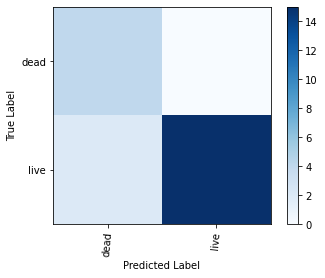

In [54]:
# Evaluate classifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert the test features for scaling
X_test_float = X_test.astype('float64')

print('Classifier Metrics:')
predictions = clf.predict(X_test)

print(metrics.classification_report(Y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(Y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Comparison of Model Accuracy

Accuracy Train:  0.9387755102040817
Accuracy Test:  0.9047619047619048


<Figure size 576x720 with 0 Axes>

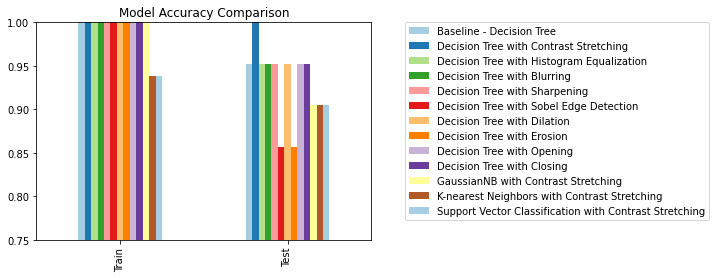

In [55]:
train_accuracy = accuracy_score(Y_train, clf.predict(X_train))
print("Accuracy Train: ", train_accuracy)
test_accuracy = accuracy_score(Y_test, clf.predict(X_test_float))
print("Accuracy Test: ", test_accuracy)

plot_compare(result, "Support Vector Classification with Contrast Stretching", train_accuracy, test_accuracy)

Support Vector Classification performs worse than Decision Tree. The test accuracy stayed at around 90% similar to Gaussian Naive Bayes and K-nearest Neighbors.

## 5.4 - Random Forest with Contrast Stretching

### Train the classification model

Now I will use the prepared image data to train a model. In this case, I will define a pipeline that contains two steps:

1. Normalize the pixel values so that they are scaled between 0 and 1 - this can prevent high pixel density values from dominating the model training.

2. Train the model using a *Random Forest* algorithm for classification.

In [56]:
# split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=1)

print('Training records:',Y_train.size)
print('Test records:',Y_test.size)

# Train the model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

# Convert the training features to floats so they can be scaled
X_train_float = X_train.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', RandomForestClassifier(random_state = 0)),
                        ])

# Use the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, Y_train)

print('classifier trained!')

Training records: 49
Test records: 21
Training model...
classifier trained!


### Evaluate the model

After training the model, I use it to predict labels for the test data and evaluate its precision, recall, and simple accuracy using the known labels. Then I plot the confusion matrix to evaluate how well the model performs for each class label.

Classifier Metrics:
              precision    recall  f1-score   support

        dead       0.80      1.00      0.89         4
        live       1.00      0.94      0.97        17

    accuracy                           0.95        21
   macro avg       0.90      0.97      0.93        21
weighted avg       0.96      0.95      0.95        21

Accuracy: 95.24%

 Confusion Matrix:


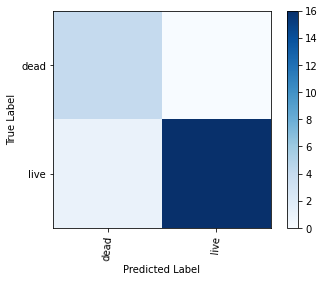

In [57]:
# Evaluate classifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert the test features for scaling
X_test_float = X_test.astype('float64')

print('Classifier Metrics:')
predictions = clf.predict(X_test)

print(metrics.classification_report(Y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(Y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Comparison of Model Accuracy

Accuracy Train:  1.0
Accuracy Test:  0.9523809523809523


<Figure size 576x720 with 0 Axes>

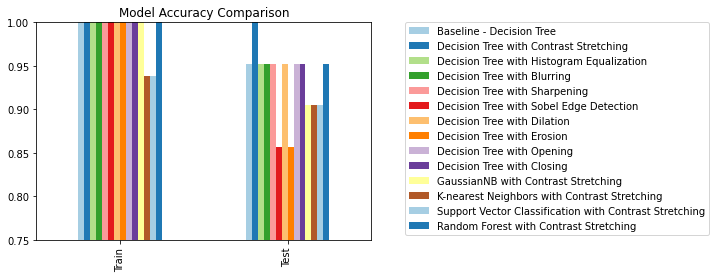

In [58]:
train_accuracy = accuracy_score(Y_train, clf.predict(X_train))
print("Accuracy Train: ", train_accuracy)
test_accuracy = accuracy_score(Y_test, clf.predict(X_test_float))
print("Accuracy Test: ", test_accuracy)

plot_compare(result, "Random Forest with Contrast Stretching", train_accuracy, test_accuracy)

Random Forest performs better than the previous 3 classifiers, but still worse than Decision Tree. The test accuracy stayed at around 95% with Random Forest with contrast stretching versus 100% for Decision Tree with constrast stretching.

## 5.5 - Gradient Boosting with Contrast Stretching

### Train the classification model

Now I will use the prepared image data to train a model. In this case, I will define a pipeline that contains two steps:

1. Normalize the pixel values so that they are scaled between 0 and 1 - this can prevent high pixel density values from dominating the model training.

2. Train the model using a *Gradient Boosting* algorithm for classification.

In [59]:
# split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=1)

print('Training records:',Y_train.size)
print('Test records:',Y_test.size)

# Train the model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier

# Convert the training features to floats so they can be scaled
X_train_float = X_train.astype('float64')

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', GradientBoostingClassifier(random_state = 0)),
                        ])

# Use the pipeline to fit a model to the training data
print("Training model...")
clf = img_pipeline.fit(X_train_float, Y_train)

print('classifier trained!')

Training records: 49
Test records: 21
Training model...
classifier trained!


### Evaluate the model

After training the model, I use it to predict labels for the test data and evaluate its precision, recall, and simple accuracy using the known labels. Then I plot the confusion matrix to evaluate how well the model performs for each class label.

Classifier Metrics:
              precision    recall  f1-score   support

        dead       1.00      1.00      1.00         4
        live       1.00      1.00      1.00        17

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

Accuracy: 100.00%

 Confusion Matrix:


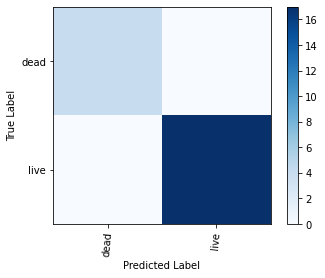

In [60]:
# Evaluate classifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert the test features for scaling
X_test_float = X_test.astype('float64')

print('Classifier Metrics:')
predictions = clf.predict(X_test)

print(metrics.classification_report(Y_test, predictions, target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(Y_test, predictions)))

print("\n Confusion Matrix:")
cm = confusion_matrix(Y_test, np.round(predictions, 0))
# Plot confusion matrix as heatmap
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Comparison of Model Accuracy

Accuracy Train:  1.0
Accuracy Test:  1.0


<Figure size 576x720 with 0 Axes>

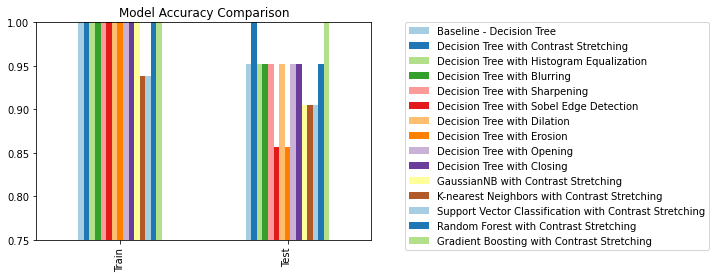

In [61]:
train_accuracy = accuracy_score(Y_train, clf.predict(X_train))
print("Accuracy Train: ", train_accuracy)
test_accuracy = accuracy_score(Y_test, clf.predict(X_test_float))
print("Accuracy Test: ", test_accuracy)

plot_compare(result, "Gradient Boosting with Contrast Stretching", train_accuracy, test_accuracy)

Finally, Gradient Boosting with contrast stretching also achieves 100% test accuracy, similar to Decision Tree with contrast stretching.

### Saving the Best Model - Gradient Boosting with Contrast Stretching

As can be seen from the comparison plot above, Gradient Boosting with contrast stretching was the only new classifier achieving also 100% accuracy which was achieved by Decision Tree with contrast stretching. So I could use both for predicting in the unseen images. I will use the last one (Gradient Boosting) since it can be already saved without training again the Decision Tree.

In [62]:
# Save the trained model
import sys
import os
import pickle

print ("Exporting the model")
file_stream = open('shape_classifier.pkl', 'wb')
pickle.dump(clf, file_stream)
file_stream.close()

Exporting the model


## 6 - Use the best model with new data
Now we can use the model to classify new images.

### Create Functions to Prepare Data and Get Class Predictions
Let's create a couple of functions to:

- Resize new images to match the size on which the model was trained.
- Submit the new images to the model and retrieve the predicted classes.

In [65]:
print(img.shape)

# Helper function to resize image
def resize_image(src_img, size=(696,520)): 
    from PIL import Image

    # rescale the image so the longest edge is the right size
    src_img.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new image of the right shape
    new_image = Image.new("L", size)
    
    # Paste the rescaled image onto the new background
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))
  
    # return the resized image
    return new_image

# Function to predict the class of an image
def predict_image(classifier, image_array):
    import numpy as np
    
    # These are the classes our model can predict
    classnames = ['dead', 'live']
    
    # Predict the class of each input image
    predictions = classifier.predict(image_array)
    
    predicted_classes = []
    for prediction in predictions:
        # And append the corresponding class name to the results
        predicted_classes.append(classnames[int(prediction)])
    # Return the predictions
    return predicted_classes

print("Functions created - ready to use model for inference.")

(520, 696)
Functions created - ready to use model for inference.


### Predict Image Classes
Now it is ready to use the model for predicting (often referred to as *inferencing*) the classes of some new images.

Importing the model


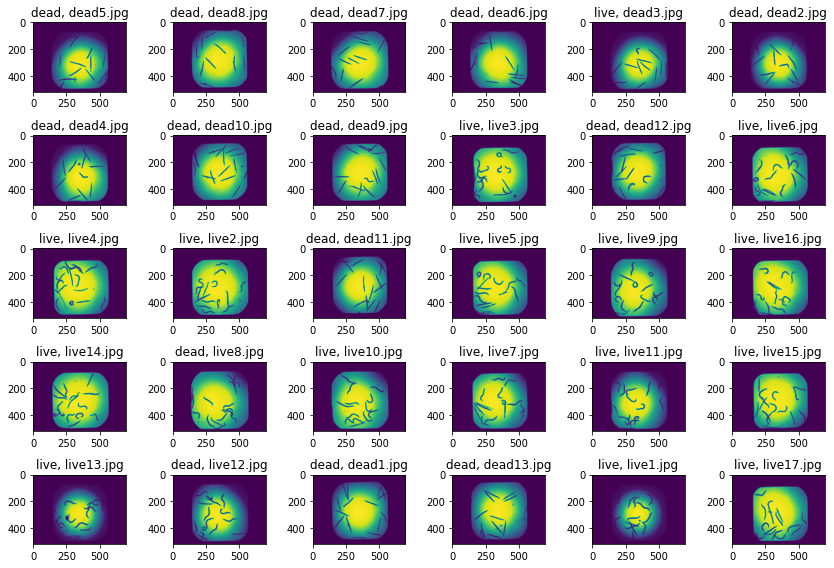

In [64]:
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

# Load the model
print("Importing the model")
file_stream = open('shape_classifier.pkl', 'rb')
clf = pickle.load(file_stream)
file_stream.close()

#get the list of test image files
test_folder = '/content/gdrive/My Drive/MBD_2021/Computer_Vision/Data/test'
test_image_files = os.listdir(test_folder)

# Empty array on which to store the images
image_arrays = []

size = (696,520)
background_color = "white"

fig = plt.figure(figsize=(12, 8))

# Get the images and show the predicted classes
for file_idx in range(len(test_image_files)):
    img = Image.open(os.path.join(test_folder, test_image_files[file_idx]))
    
    # resize the image so it matches the training set - it  must be the same size as the images on which the model was trained
    resized_img = np.array(resize_image(img, size))

    img_shape = np.array(resized_img).shape

     # Contrast stretching
    xp = [0, 64, 128, 192, 255]
    fp = [0, 16, 128, 240, 255]
    x = np.arange(256)
    table = np.interp(x, xp, fp).astype('uint8')
    resized_img = cv2.LUT(resized_img, table)
                      
    # Add the image to the array of images
    image_arrays.append(resized_img.ravel())

# Get predictions from the array of image arrays
# Note that the model expects an array of 1 or more images - just like the batches on which it was trained
predictions = predict_image(clf, np.array(image_arrays))

# plot easch image with its corresponding prediction
for idx in range(len(predictions)):
    a=fig.add_subplot(5,6, idx+1)
    img = image_arrays[idx].reshape(img_shape)
    imgplot = plt.imshow(img)
    file_list=os.listdir(r"/content/gdrive/My Drive/MBD_2021/Computer_Vision/Data/test")
    a.set_title(predictions[idx]+', '+file_list[idx])
    fig.tight_layout()

Above I have added to the plot title the model prediction and the name of the image file (which I have previously renamed to include the name of the corresponding class live or dead). 

Therefore, I can visually check that from the 30 unseen images, only 3 images were wrongly classified (1 dead image classified as live and 2 live images classified as dead).

## 7 - Conclusion

- In this assignment I have tested different classifiers and different images transformations on a C-Elegans dataset.

- The image transformations included contrast improvement operations such as histogram equalization, image filtering such as blurring and morphological operations such as dilation, among others.

- Classifiers such as Decision Tree, Random Forest and Gradient Boosting, among others, were trained.

- 49 images were used to train the models and 21 images were used to test the models. The Decision Tree model with contrast stretching and the Gradient Boosting model with contrast stretching were the best models achieving 100% test accuracy predicting the 2 classes dead and live.

- Finally, the Gradient Boosting model with contrast stretching was used to predict 30 new unseen images and only missed classifying 3 of the classes.